### Eliminación de sesgos del dataset (primera aproximación)
La premisa detrás de esta estrategia de eliminación de sesgos se centra en lograr un equilibrio en las clases de "edad", "género" y "raza" mediante la eliminación de imágenes del conjunto de datos con mayor cantidad y la generación de nuevas imágenes a partir de las que se encuentran en el conjunto con menor cantidad. Dado que muchos de los modelos que usan este dataset tienen como objetivo principal la predicción de la edad y al realizar un análisis de la distribución de las imagenes con respecto a la misma nos percatamos que existe un desbalance considerable por lo que el algoritmo propuesto prioriza las edades con mayor y menor cantidad de imagenes. Una vez con estos grupos definidos se buscan aquellos donde el par género-raza sea mayor/menor, se considera la tupla para igualar las prioridades de ambas clases.

Primero importamos los módulos necesarios

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import random as rnd

from shutil import copy2
from utils import augment_image

Se definen la ruta donde se encuentra el dataset original y la ruta donde se creará el nuevo sin sesgos. Al leer las imágenes del dataset nos percatamos que existen algunas con los tag incompletos, por lo que decidimos retirarlas ya que serían un problema para el algoritmo.

In [4]:
origin_path = '../datasets/UTKFace_origin/'
debiased_path = '../datasets/UTKFace_debiased/'
images = os.listdir(origin_path)
count = 0
conflicted = []
for i in images:
    splited_i = i.split('_')
    if len(splited_i) < 4:
        count += 1
        print(i)
        conflicted.append(i)
        
for i in conflicted:
    images.remove(i)

39_1_20170116174525125.jpg.chip.jpg
61_1_20170109142408075.jpg.chip.jpg
61_1_20170109150557335.jpg.chip.jpg


Una vez cargadas la imágenes y filtradas las problemáticas elaboramos los conjuntos: "imágenes", "edades", "géneros" y "razas" para luego juntarlos en un dataframe.

In [5]:

ages = []
genders = []
races = []
for i in images:
    split = i.split('_')
    ages.append(int(split[0]))
    genders.append(int(split[1]))
    races.append(int(split[2]))
    

In [6]:
pd_images = pd.Series(list(images), name = 'Images')
pd_ages = pd.Series(list(ages), name = 'Ages')
pd_genders = pd.Series(list(genders), name = 'Genders')
pd_races = pd.Series(list(races), name = 'Races')

df = pd.concat([pd_images, pd_ages, pd_genders, pd_races], axis=1)
df

,Images,Ages,Genders,Races
0,100_0_0_20170112213500903.jpg.chip.jpg,100,0,0
1,100_0_0_20170112215240346.jpg.chip.jpg,100,0,0
2,100_1_0_20170110183726390.jpg.chip.jpg,100,1,0
3,100_1_0_20170112213001988.jpg.chip.jpg,100,1,0
4,100_1_0_20170112213303693.jpg.chip.jpg,100,1,0
...,...,...,...,...
23700,9_1_3_20161220222856346.jpg.chip.jpg,9,1,3
23701,9_1_3_20170104222949455.jpg.chip.jpg,9,1,3
23702,9_1_4_20170103200637399.jpg.chip.jpg,9,1,4
23703,9_1_4_20170103200814791.jpg.chip.jpg,9,1,4


#### Análisis de las edades
Una vez graficado el conjunto de edades destaca la dispareja distribución de los datos. Para edades mayor a 80 el dataset tiene un bajo volumen de datos y para edades en rangos como (1,4) y (25,30) una alta concentración.

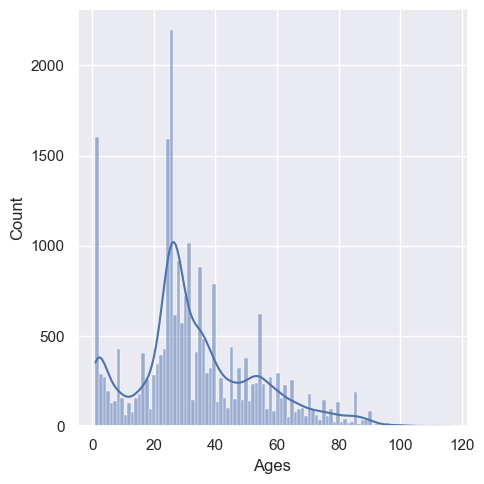

In [7]:
sns.set_theme()
sns.displot(df['Ages'],kde=True, bins=100)

In [8]:
ages_count = [0] * pd_ages.max()
ages_count = pd.Series(list(ages_count), name = 'Ages Count')
for age in ages:
    ages_count[age-1] += 1
ages_median = ages_count.median()
print(list(ages_count), ages_median)

[1123, 482, 289, 273, 196, 131, 139, 263, 166, 156, 65, 130, 81, 157, 177, 247, 158, 262, 98, 284, 346, 395, 426, 859, 734, 2197, 615, 918, 570, 724, 350, 664, 143, 409, 880, 483, 293, 325, 265, 526, 132, 266, 157, 100, 440, 153, 170, 153, 148, 381, 138, 232, 241, 353, 268, 236, 97, 271, 82, 293, 159, 125, 103, 50, 259, 77, 94, 100, 56, 147, 33, 98, 63, 32, 148, 58, 28, 69, 23, 133, 22, 40, 18, 24, 155, 35, 10, 34, 33, 82, 2, 13, 5, 0, 9, 17, 0, 0, 9, 11, 2, 0, 1, 0, 5, 0, 0, 0, 0, 5, 1, 0, 0, 0, 3, 4] 131.5


#### Análisis de género
En el género también nos encontramos con desbalance de clases teniendo un diferencia de aproximadamente mil elementos entre ambos conjuntos.

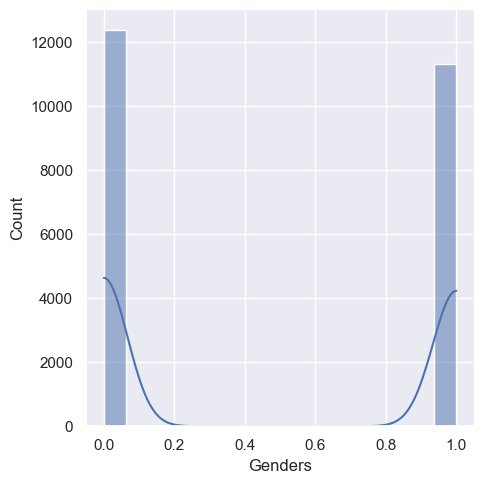

In [9]:
graph = sns.displot(df['Genders'],kde=True)

#### Análisis de raza
En el caso de la raza, se presenta una situación similar a la descrita anteriormente para las variables "edad" y "género". Se observa un desequilibrio significativo de personas blancas con respecto a negros, chinos, etc.

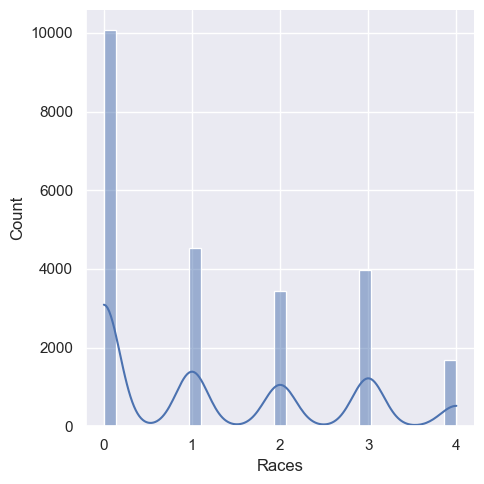

In [10]:
graph = sns.displot(df['Races'],kde=True)

### Depuración del dataset
Para la depuración del dataset no apoyaremos en un diccionario donde las llaves son el conjunto de edades y los valores un segundo diccionario. Este segundo diccionario esta conformado por tuplas género-raza para las llaves y lista de imágenes para los valores

In [11]:
ages_groups = {}

for i in range(len(images)):
    age = ages[i]
    gender = genders[i]
    race = races[i]
    image = images[i]
    
    if age not in ages_groups:
        ages_groups[age] = {}
    if (gender,race) not in ages_groups[age]:
        ages_groups[age][(gender, race)] = []
    ages_groups[age][(gender, race)].append(image)   

ages_groups

{100: {(0, 0): ['100_0_0_20170112213500903.jpg.chip.jpg',
   '100_0_0_20170112215240346.jpg.chip.jpg'],
  (1, 0): ['100_1_0_20170110183726390.jpg.chip.jpg',
   '100_1_0_20170112213001988.jpg.chip.jpg',
   '100_1_0_20170112213303693.jpg.chip.jpg',
   '100_1_0_20170112215032192.jpg.chip.jpg',
   '100_1_0_20170117195420803.jpg.chip.jpg',
   '100_1_0_20170119212053665.jpg.chip.jpg'],
  (1, 2): ['100_1_2_20170105174847679.jpg.chip.jpg',
   '100_1_2_20170112213615815.jpg.chip.jpg',
   '100_1_2_20170112222336458.jpg.chip.jpg']},
 101: {(0, 0): ['101_0_0_20170112213500903.jpg.chip.jpg'],
  (1, 2): ['101_1_2_20170105174739309.jpg.chip.jpg']},
 103: {(0, 2): ['103_0_2_20170112213001988.jpg.chip.jpg']},
 105: {(0, 0): ['105_0_0_20170112213001988.jpg.chip.jpg'],
  (1, 0): ['105_1_0_20170112213001988.jpg.chip.jpg',
   '105_1_0_20170112213021902.jpg.chip.jpg',
   '105_1_0_20170112213507183.jpg.chip.jpg'],
  (1, 1): ['105_1_1_20170112213303693.jpg.chip.jpg']},
 10: {(0, 0): ['10_0_0_20161220222308131

#### Submuestreo
Definimos un método que recibe el grupo del que queremos eliminar datos, la mediana de valores que es el tamaño de ideal para el grupo y un epsilon que permite valores cercanos a ese tamaño ideal pero no necesariamente el mismo.

In [12]:
def undersample(group, median, epsilon):
    
    for age in group:
        ages_count = sum(len(group[age][(gender,race)]) for (gender,race) in group[age])
        rnd_bounder = rnd.randint(0,epsilon)
        while ages_count > median + rnd_bounder:
            max_group = max(group[age], key=lambda x: len(group[age][x]))
            images = group[age][max_group]
            index = rnd.randint(0, len(images)-1)
            print('Removing', images[index], 'from', age, max_group, 'group')
            images.pop(index)
            ages_count -= 1

Aplicamos el submuestreo a todos los grupos y a aquellos que tengan una excesiva cantidad de datos se les eliminaran elementos de manera aleatoria.

In [13]:
undersample(ages_groups, ages_median, 15)

Removing 10_0_0_20170110220403810.jpg.chip.jpg from 10 (0, 0) group
Removing 10_0_0_20170110221719390.jpg.chip.jpg from 10 (0, 0) group
Removing 10_0_0_20170110220530650.jpg.chip.jpg from 10 (0, 0) group
Removing 10_0_0_20170110225502403.jpg.chip.jpg from 10 (0, 0) group
Removing 10_0_0_20170110220033115.jpg.chip.jpg from 10 (0, 0) group
Removing 10_0_0_20170103233459275.jpg.chip.jpg from 10 (0, 0) group
Removing 10_0_0_20170103200329407.jpg.chip.jpg from 10 (0, 0) group
Removing 10_0_0_20170110225451638.jpg.chip.jpg from 10 (0, 0) group
Removing 10_0_0_20170110220251986.jpg.chip.jpg from 10 (0, 0) group
Removing 10_0_0_20170110225035898.jpg.chip.jpg from 10 (0, 0) group
Removing 10_0_0_20170110225601897.jpg.chip.jpg from 10 (0, 0) group
Removing 10_0_0_20170110220548521.jpg.chip.jpg from 10 (0, 0) group
Removing 10_0_0_20170110220514186.jpg.chip.jpg from 10 (0, 0) group
Removing 14_1_0_20170104011733528.jpg.chip.jpg from 14 (1, 0) group
Removing 14_1_0_20170104011720664.jpg.chip.jpg f

In [14]:
a = [0] * max(ages_groups.keys())

for key, subgroups in ages_groups.items():
    count = sum(map(lambda x: len(x[1]), subgroups.items()))
    a[key-1] = count
    
print(a)
print(sum(a))
    

[135, 135, 139, 145, 142, 131, 139, 140, 132, 143, 65, 130, 81, 131, 142, 142, 146, 139, 98, 131, 142, 136, 134, 132, 135, 139, 145, 139, 139, 132, 142, 131, 133, 139, 138, 144, 143, 145, 143, 146, 131, 139, 142, 100, 145, 146, 146, 135, 136, 146, 132, 135, 139, 144, 132, 140, 97, 141, 82, 134, 134, 125, 103, 50, 133, 77, 94, 100, 56, 138, 33, 98, 63, 32, 136, 58, 28, 69, 23, 133, 22, 40, 18, 24, 135, 35, 10, 34, 33, 82, 2, 13, 5, 0, 9, 17, 0, 0, 9, 11, 2, 0, 1, 0, 5, 0, 0, 0, 0, 5, 1, 0, 0, 0, 3, 4]
10208


Como podemos apreciar en la gráfica a continuación todos los conjuntos de edades con cantidades mayores a la mediana más epsilon fueron reducidos.

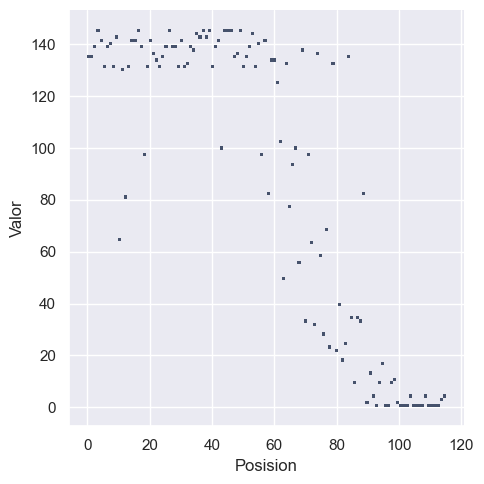

In [15]:
y = range(len(a))
pd_undersampled_ages = pd.DataFrame({'Posision': y, 'Valor': a})
sns.displot(pd_undersampled_ages, x='Posision', y='Valor', bins=len(a))

In [16]:
for age in ages_groups:
    for tuple in ages_groups[age]:
        for image in ages_groups[age][tuple]:
            copy2(origin_path + image, debiased_path)

#### Sobremuestreo
En los conjuntos de edades donde ocurre lo contrario, tenemos pocos datos, debemos hacer "Data Augmentation". En este caso trabajaremos con "Reflejo Horizontal", "Rotación Aleatoria", "Desenfoque Gaussiano", y "Ruido Gaussiano" para crear imagenes a partir de las que tenemos.

In [17]:
def oversample(group, median, epsilon):
    count_generated_images = 0
    for age in group:
        if age > 90:
            continue
        ages_count = sum(len(group[age][(gender,race)]) for (gender,race) in group[age])
        while ages_count < median - epsilon:
            min_group = min(group[age], key=lambda x: len(group[age][x]))
            aux_images = group[age][min_group]
            index = rnd.randint(0, len(aux_images)-1)
            img_name = augment_image(aux_images[index], debiased_path, debiased_path, count_generated_images)
            aux_images.append(img_name)
            ages_count += 1

In [18]:
oversample(ages_groups, ages_median, 5)

### Evaluación del Dataset resultante
Para evaluar el dataset resultante de la mitigación de sesgos realizamos las mismas operaciones de carga de archivo y construcción del dataframe.

In [19]:
origin_path = '../datasets/UTKFace_debiased/'
images = os.listdir(origin_path)
count = 0
conflicted = []
for i in images:
    splited_i = i.split('_')
    if len(splited_i) < 4:
        count += 1
        print(i)
        conflicted.append(i)
        
for i in conflicted:
    images.remove(i)

ages = []
genders = []
races = []
for i in images:
    split = i.split('_')
    ages.append(int(split[0]))
    genders.append(int(split[1]))
    races.append(int(split[2]))
    
pd_images = pd.Series(list(images), name = 'Images')
pd_ages = pd.Series(list(ages), name = 'Ages')
pd_genders = pd.Series(list(genders), name = 'Genders')
pd_races = pd.Series(list(races), name = 'Races')

df = pd.concat([pd_images, pd_ages, pd_genders, pd_races], axis=1)
df

,Images,Ages,Genders,Races
0,100_0_0_20170112213500903.jpg.chip.jpg,100,0,0
1,100_0_0_20170112215240346.jpg.chip.jpg,100,0,0
2,100_1_0_20170110183726390.jpg.chip.jpg,100,1,0
3,100_1_0_20170112213001988.jpg.chip.jpg,100,1,0
4,100_1_0_20170112213303693.jpg.chip.jpg,100,1,0
...,...,...,...,...
11077,9_1_3_20161220222856346.jpg.chip.jpg,9,1,3
11078,9_1_3_20170104222949455.jpg.chip.jpg,9,1,3
11079,9_1_4_20170103200637399.jpg.chip.jpg,9,1,4
11080,9_1_4_20170103200814791.jpg.chip.jpg,9,1,4


Resultados del nuevo dataset

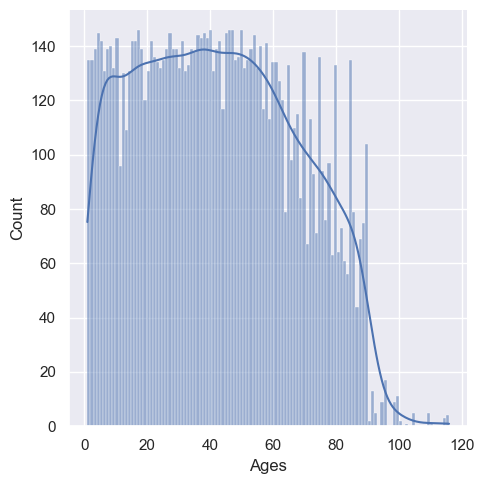

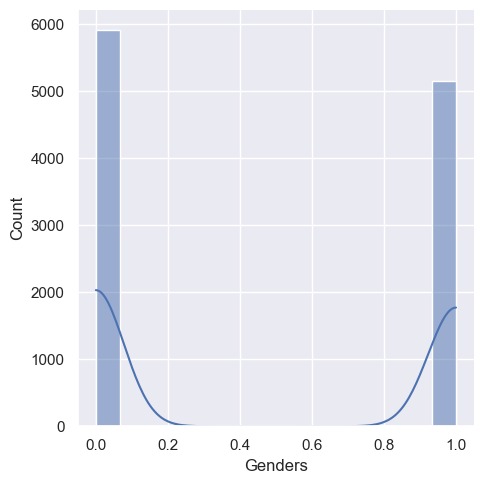

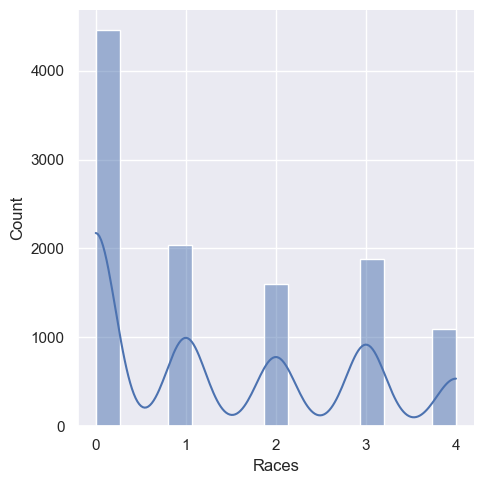

: 

In [20]:
sns.displot(df['Ages'],kde=True, bins=116)
sns.displot(df['Genders'],kde=True)
sns.displot(df['Races'],kde=True)

Como podemos observar en las gráficas obtuvimos un buen balance de las edades pero no el suficiente en género y raza, por lo que intentaremos una segunda aproximación en el siguiente notebook "ds_analysis_second_approach"